In [1]:
%matplotlib inline
import os, sys, gc
import shutil
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import gridspec
import matplotlib.image as mpimg

from scipy.stats import pearsonr as pr

import collections

def sba(model_predictions, human_predictions):
    """Returns second best accuracy score (of wrong images)"""
    total = model_predictions.shape[0]
    right = 0
    for i in np.arange(total):
        msb = np.argsort(model_predictions[i])[-2] # takes second best
        lab = np.argmax(human_predictions[i])
        right += (msb == lab)
    return right / total


In [2]:
loadDir = 'base_predictions'
postDir = 'post'
saveDir = 'figures'
# raw bins
bins = np.load('{0}/human_bincounts.npy'.format(loadDir))
#correct = np.argmax(bins, axis = 1)
#print(correct[:5])
#raw probabilities
humans = bins / np.sum(bins, axis = 1)[:, np.newaxis]
max_prob = np.max(humans, axis = 1)
humans_correct = np.argmax(humans, axis = 1)
humans_smoothed = (bins + 1) / np.sum(bins, axis = 1)[:, np.newaxis]

validation_idx = np.load('./val_idx_seed_0.npy')
print('val idx shape: ', validation_idx.shape)

ordered_filenames = np.load('{0}/decoded_test_filename_order.npy'.format(loadDir))

labels = ['P', 'A', 'B', 'C', 'De', 'Do', 'F', 'H', 'S', 'T']

im_dir = '/home/battleday/Academic/Berkeley/Superman/local/images/train_set_combined'

val idx shape:  (1000,)


In [3]:
np.shape(np.intersect1d(validation_idx, np.arange(10000)))

(1000,)

In [4]:
test_files = os.listdir('{0}/test/'.format(loadDir))
print(test_files)
test_files = sorted([p for p in test_files if p[-4:] == '.npz'])
print(test_files)
test_files.remove('resnet_preact_bottleneck_164_test.npz')
print(test_files)

test_dict = collections.OrderedDict()
for m in test_files:
    raw = np.load('{0}/test/{1}'.format(loadDir, m))
    model = m.split('.')[0]
    test_dict[model] = {}
    for prop in raw.keys(): 
        test_dict[model][prop] = raw[prop]
print(test_dict.keys())


['shake_shake_26_2x64d_SSI_cutout16_test.npz', 'resnext_29_8x64d_test.npz', 'resnet_basic_110_test.npz', 'vgg_15_BN_64_test.npz', 'wrn_28_10_test.npz', 'pyramidnet_basic_110_270_test.npz', 'resnet_preact_bottleneck_164_test.npz', 'densenet_BC_100_12_test.npz']
['densenet_BC_100_12_test.npz', 'pyramidnet_basic_110_270_test.npz', 'resnet_basic_110_test.npz', 'resnet_preact_bottleneck_164_test.npz', 'resnext_29_8x64d_test.npz', 'shake_shake_26_2x64d_SSI_cutout16_test.npz', 'vgg_15_BN_64_test.npz', 'wrn_28_10_test.npz']
['densenet_BC_100_12_test.npz', 'pyramidnet_basic_110_270_test.npz', 'resnet_basic_110_test.npz', 'resnext_29_8x64d_test.npz', 'shake_shake_26_2x64d_SSI_cutout16_test.npz', 'vgg_15_BN_64_test.npz', 'wrn_28_10_test.npz']
odict_keys(['densenet_BC_100_12_test', 'pyramidnet_basic_110_270_test', 'resnet_basic_110_test', 'resnext_29_8x64d_test', 'shake_shake_26_2x64d_SSI_cutout16_test', 'vgg_15_BN_64_test', 'wrn_28_10_test'])


In [5]:
post_files = os.listdir('{0}/'.format(postDir))
#print(post_files)
post_files = sorted([p for p in post_files if p[-4:] == '.npz'])
#print(post_files)

post_dict = collections.OrderedDict()
for m in post_files:
    raw = np.load('{0}/{1}'.format(postDir, m))
    model = m.split('.')[0]
    post_dict[model] = {}
    for prop in raw.keys(): 
        post_dict[model][prop] = raw[prop]
print(post_dict.keys())



odict_keys(['densenet_BC_100_12_test', 'pyramidnet_basic_110_270_test', 'resnet_basic_110_test', 'resnext_29_8x64d_test', 'shake_shake_26_2x64d_SSI_cutout16_test', 'vgg_15_BN_64_test', 'wrn_28_10_test'])


In [6]:
accuracies = []
sbas = []
val_sbas = []
val_accuracies = []
for model, value in test_dict.items():
    print(model)
    value['top_guess'] = np.argmax(value['probs'], axis=1)
    value['wrong_idx_labels'] = np.where(value['top_guess'] != test_dict[model]['labels'])[0]
    value['wrong_idx'] = np.where(value['top_guess'] != humans_correct)[0]
    
    value['overlap'] = np.intersect1d(validation_idx, value['wrong_idx'])
    print('validation idx overlap with wrong idx human: ', np.shape(value['overlap']))
    value['overlap_labels'] = np.intersect1d(validation_idx, value['wrong_idx_labels'])
    print('validation idx overlap with wrong idx labels: ', np.shape(value['overlap']))

    value['sba'] = sba(value['probs'][value['wrong_idx']], humans[value['wrong_idx']])
    value['validation_sba'] = sba(value['probs'][value['overlap']], humans[value['overlap']])
    value['accuracy'] = 1 - (np.shape(value['wrong_idx'])[0] / 10000)
    value['validation_accuracy'] = 1 - (np.shape(value['overlap'])[0] / 1000)
    print('num errors:', np.shape(value['wrong_idx']), 'accuracy: ', value['accuracy'])
    print('sba: ', value['sba'])
    print('validation sba: ', value['validation_sba'])
    print('validation accuracy: ', value['validation_accuracy'])
    accuracies.append(value['accuracy'])
    sbas.append(value['sba'])
    val_sbas.append(value['validation_sba'])
    val_accuracies.append(value['validation_accuracy'])


densenet_BC_100_12_test
validation idx overlap with wrong idx human:  (39,)
validation idx overlap with wrong idx labels:  (39,)
num errors: (456,) accuracy:  0.9544
sba:  0.668859649122807
validation sba:  0.7435897435897436
validation accuracy:  0.961
pyramidnet_basic_110_270_test
validation idx overlap with wrong idx human:  (34,)
validation idx overlap with wrong idx labels:  (34,)
num errors: (397,) accuracy:  0.9603
sba:  0.6599496221662469
validation sba:  0.6176470588235294
validation accuracy:  0.966
resnet_basic_110_test
validation idx overlap with wrong idx human:  (58,)
validation idx overlap with wrong idx labels:  (58,)
num errors: (606,) accuracy:  0.9394
sba:  0.6534653465346535
validation sba:  0.6379310344827587
validation accuracy:  0.942
resnext_29_8x64d_test
validation idx overlap with wrong idx human:  (35,)
validation idx overlap with wrong idx labels:  (35,)
num errors: (377,) accuracy:  0.9623
sba:  0.6896551724137931
validation sba:  0.6285714285714286
validat

(0.5668432863224355, 0.18452927483026318)
(0.17477382271675623, 0.7078054670325371)


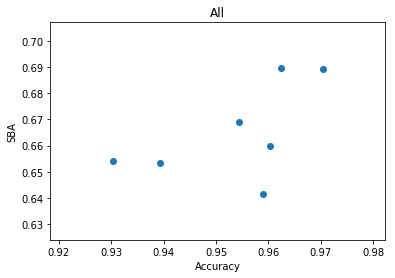

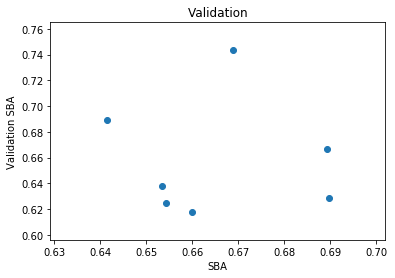

In [7]:
plt.scatter(accuracies, sbas)
plt.title('All')
plt.xlabel('Accuracy')
plt.ylabel('SBA')
print(pr(accuracies, sbas))

plt.figure()
plt.scatter(sbas, val_sbas)
plt.title('Validation')
plt.xlabel('SBA')
plt.ylabel('Validation SBA')
print(pr(val_accuracies, val_sbas))

In [8]:
accuracies_post = []
models_post = []
sbas_post = []
val_sbas_post = []
val_accuracies_post = []
for model, value in post_dict.items():
    print(model)
    models_post.append(model)
    value['top_guess'] = np.argmax(value['probs'], axis=1)
    value['wrong_idx'] = np.where(value['top_guess'] != humans_correct)[0]
    value['overlap'] = np.intersect1d(validation_idx, value['wrong_idx'])
    print('validation idx overlap with wrong idx: ', np.shape(value['overlap']))
    value['sba'] = sba(value['probs'][value['wrong_idx']], humans[value['wrong_idx']])
    value['validation_sba'] = sba(value['probs'][value['overlap']], humans[value['overlap']])
    value['accuracy'] = 1 - (np.shape(value['wrong_idx'])[0] / 10000)
    value['validation_accuracy'] = 1 - (np.shape(value['overlap'])[0] / 1000)
    print('num errors:', np.shape(value['wrong_idx']), 'accuracy: ', value['accuracy'])
    print('sba: ', value['sba'])
    print('validation sba: ', value['validation_sba'])
    print('validation accuracy: ', value['validation_accuracy'])
    accuracies_post.append(value['accuracy'])
    sbas_post.append(value['sba'])
    val_sbas_post.append(value['validation_sba'])
    val_accuracies_post.append(value['validation_accuracy'])


densenet_BC_100_12_test
validation idx overlap with wrong idx:  (55,)
num errors: (118,) accuracy:  0.9882
sba:  0.864406779661017
validation sba:  0.7636363636363637
validation accuracy:  0.945
pyramidnet_basic_110_270_test
validation idx overlap with wrong idx:  (40,)
num errors: (109,) accuracy:  0.9891
sba:  0.908256880733945
validation sba:  0.825
validation accuracy:  0.96
resnet_basic_110_test
validation idx overlap with wrong idx:  (65,)
num errors: (123,) accuracy:  0.9877
sba:  0.7804878048780488
validation sba:  0.676923076923077
validation accuracy:  0.935
resnext_29_8x64d_test
validation idx overlap with wrong idx:  (38,)
num errors: (83,) accuracy:  0.9917
sba:  0.8433734939759037
validation sba:  0.6578947368421053
validation accuracy:  0.962
shake_shake_26_2x64d_SSI_cutout16_test
validation idx overlap with wrong idx:  (31,)
num errors: (82,) accuracy:  0.9918
sba:  0.926829268292683
validation sba:  0.8064516129032258
validation accuracy:  0.969
vgg_15_BN_64_test
valid

['densenet BC 100 12', 'pyramidnet basic 110 270', 'resnet basic 110', 'resnext 29 8x64d', 'shake shake 26 2x64d SSI cutout16', 'vgg 15 BN 64', 'wrn 28 10']


0.09153924747827971

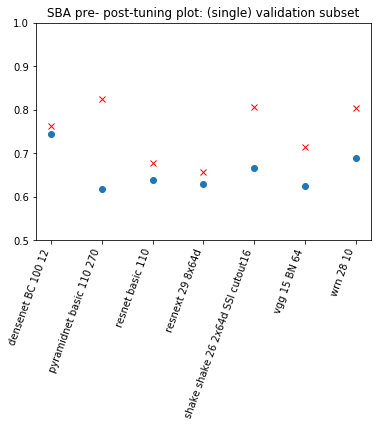

In [9]:
models_new = [(' ').join(x.split('_')[:-1]) for x in models_post]
print(models_new)
plt.figure()
plt.title('SBA pre- post-tuning plot: (single) validation subset')
plt.ylim([0.5, 1])
plt.plot(models_new, val_sbas, marker='o', linewidth=0)
plt.plot(models_new, val_sbas_post, 'r', marker='x', linewidth=0)
plt.xticks(rotation=70, ha='right')
np.mean(np.array(val_sbas_post) - np.array(val_sbas))

In [10]:
averageTestProb = []
for key, value in test_dict.items():
    correct = value['labels']
    averageTestProb.append(value['probs'])
averageTestProb = np.mean(averageTestProb, axis=0)
print(averageTestProb.shape, np.argmax(averageTestProb, axis = 1))
print(correct)
correctProb = averageTestProb[np.arange(correct.shape[0]), correct]
print(correctProb.shape)

top = np.argsort(correctProb)[:2000]
print(top.shape, top[:5], correctProb[top[5:]])

human_correct = np.argmax(humans, axis = 1)
human_correct_prob = np.max(humans, axis = 1)
print('hcp[:3]', human_correct_prob[:3])
print(human_correct.shape)
agg_NN_correct = np.argmax(averageTestProb, axis = 1)
print(agg_NN_correct.shape)
print(np.mean(human_correct != agg_NN_correct))
print(np.mean(correct != agg_NN_correct))
print(np.mean(human_correct != correct))

print(1 - soft_certain(humans[top]))

(10000, 10) [3 8 8 ... 5 1 7]
[3 8 8 ... 5 1 7]
(10000,)
(2000,) [2405 9227 4965 4740 7099] [2.2203814e-04 5.2840303e-04 5.5363262e-04 ... 9.8744613e-01 9.8745674e-01
 9.8746258e-01]
hcp[:3] [0.94117647 0.98039216 1.        ]
(10000,)
(10000,)
0.0322
0.0299
0.0079


NameError: name 'soft_certain' is not defined

In [ ]:
averageEnt = []
for key, value in test_dict.items():
    averageEnt.append(value['entropy'])
averageEnt = np.mean(averageEnt, axis=0)
print(averageEnt.shape)

In [ ]:
# ent to ent
plt.figure()
plt.scatter(averageEnt, human_ent)
print('av ent to ent, all', pr(averageEnt, human_ent))

plt.figure()
plt.scatter(averageEnt[top], human_ent[top])

print('av ent to ent, top', pr(averageEnt[top], human_ent[top]))


plt.figure()
plt.scatter(correctProb, human_ent)
print('av prob to ent, all', pr(correctProb, human_ent))


plt.figure()
plt.scatter(correctProb[top], human_ent[top])
print('av prob to ent, top', pr(correctProb[top], human_ent[top]))


plt.figure()
plt.scatter(correctProb, human_correct_prob)
print('prob to prob, all', pr(correctProb, human_correct_prob))

plt.figure()
plt.scatter(correctProb[top], human_correct_prob[top])
print('prob to prob, top',pr(correctProb[top], human_correct_prob[top]))

In [ ]:
plt.figure()
plt.hist(human_ent[top])
plt.title('NN bottom 20% test set')
plt.xlim([0, 2])
plt.xlabel('Entropy post smoothing')
plt.ylim([0, 1000])
plt.ylabel('#')

plt.figure()
plt.hist(human_ent)
plt.title('All test set')
plt.xlim([0, 2])
plt.ylabel('#')
plt.ylim([0, 5000])
plt.xlabel('Entropy post smoothing')
